Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
train_subset = 1000
beta = 0.01

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.constant(
        train_dataset[:train_subset, :]
    )
    tf_train_labels = tf.constant(
        train_labels[:train_subset]
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(tf_test_datast, weights) + biases
    )

Initialized
Loss at step 0: 18.625324
Training accuracy: 7.9%
Validation accuracy: 9.4%

Loss at step 100: 0.867004
Training accuracy: 80.6%
Validation accuracy: 68.4%

Loss at step 200: 0.396087
Training accuracy: 90.0%
Validation accuracy: 72.5%

Loss at step 300: 0.301526
Training accuracy: 93.5%
Validation accuracy: 75.3%

Loss at step 400: 0.282466
Training accuracy: 95.0%
Validation accuracy: 77.1%

Loss at step 500: 0.278939
Training accuracy: 95.3%
Validation accuracy: 77.9%

Loss at step 600: 0.278273
Training accuracy: 95.4%
Validation accuracy: 78.3%

Loss at step 700: 0.278039
Training accuracy: 95.4%
Validation accuracy: 78.5%

Loss at step 800: 0.277868
Training accuracy: 95.4%
Validation accuracy: 78.5%

Loss at step 900: 0.277726
Training accuracy: 95.4%
Validation accuracy: 78.6%

Loss at step 1000: 0.277614
Training accuracy: 95.4%
Validation accuracy: 78.6%

Test accuracy: 86.0%


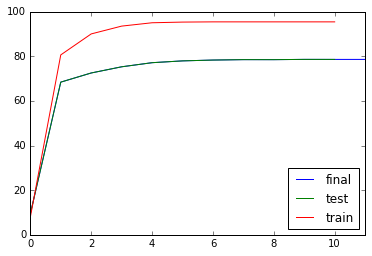

In [6]:
%matplotlib inline
import pandas as pd

def getTFResults(graph, num_iterations):

    def accuracy(predictions, labels):
        return (
            100.0 * np.sum(
                np.argmax(predictions, 1) == np.argmax(labels, 1)
            ) / predictions.shape[0]
        )

    df_accuracy = []

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        print('Initialized')

        for step in range(num_iterations):
            _, l, predictions = session.run([optimizer, loss, train_prediction])

            if (step % 100 == 0):
                print('Loss at step %d: %f' % (step, l))
                print(
                    'Training accuracy: %.1f%%' % accuracy(
                        predictions,
                        train_labels[:train_subset, :]
                    )
                )
                print(
                    'Validation accuracy: %.1f%%' % accuracy(
                        valid_prediction.eval(),
                        valid_labels
                    )
                )
                print('')

                df_accuracy.append({
                    'step': step,
                    'train': accuracy(
                        predictions,
                        train_labels[:train_subset, :]
                    ),
                    'test': accuracy(
                        valid_prediction.eval(),
                        valid_labels
                    ),
                    'final': accuracy(
                        valid_prediction.eval(),
                        valid_labels
                    )
                })
        print(
            'Test accuracy: %.1f%%' % accuracy(
                test_prediction.eval(),
                test_labels
            )
        )

        df_accuracy.append({
            'step': step,
            'final': accuracy(
                valid_prediction.eval(),
                valid_labels
            )
        })
    df_accuracy = pd.DataFrame(df_accuracy)

    df_accuracy[['final', 'test', 'train']].plot()

getTFResults(graph, 1001)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized
Loss at step 0: 14.774579
Training accuracy: 18.0%
Validation accuracy: 15.1%

Loss at step 100: 0.037425
Training accuracy: 100.0%
Validation accuracy: 43.8%

Loss at step 200: 0.035023
Training accuracy: 100.0%
Validation accuracy: 49.3%

Loss at step 300: 0.039231
Training accuracy: 100.0%
Validation accuracy: 55.6%

Loss at step 400: 0.041690
Training accuracy: 100.0%
Validation accuracy: 60.6%

Loss at step 500: 0.042650
Training accuracy: 100.0%
Validation accuracy: 62.8%

Loss at step 600: 0.042935
Training accuracy: 100.0%
Validation accuracy: 64.1%

Loss at step 700: 0.042985
Training accuracy: 100.0%
Validation accuracy: 64.5%

Loss at step 800: 0.042974
Training accuracy: 100.0%
Validation accuracy: 64.9%

Loss at step 900: 0.042951
Training accuracy: 100.0%
Validation accuracy: 65.1%

Loss at step 1000: 0.042928
Training accuracy: 100.0%
Validation accuracy: 65.1%

Test accuracy: 71.5%


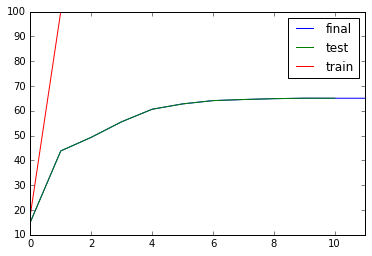

In [7]:
train_subset = 100
beta = 0.01

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.constant(
        train_dataset[:train_subset, :]
    )
    tf_train_labels = tf.constant(
        train_labels[:train_subset]
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(tf_test_datast, weights) + biases
    )
    
getTFResults(graph, 1001)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [8]:
batch_size = 128
beta = 0.001

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )

Initialized
Minibatch loss at step 0: 526.605652
Minibatch loss at step 500: 26.460552
Minibatch loss at step 1000: 14.115677
Minibatch loss at step 1500: 10.033611
Minibatch loss at step 2000: 5.278525
Minibatch loss at step 2500: 4.963735
Minibatch loss at step 3000: 3.709082
Minibatch loss at step 3500: 4.581806
Minibatch loss at step 4000: 7.460015
Minibatch loss at step 4500: 6.529222
Minibatch loss at step 5000: 5.690063
Minibatch loss at step 5500: 3.268908
Minibatch loss at step 6000: 2.245099
Minibatch loss at step 6500: 1.837659
Minibatch loss at step 7000: 6.448146
Minibatch loss at step 7500: 2.333241
Minibatch loss at step 8000: 4.474006
Minibatch loss at step 8500: 1.420635
Minibatch loss at step 9000: 3.735660
Test accuracy: 88.7%


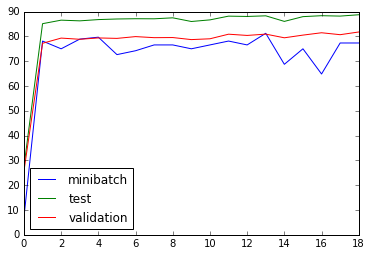

In [9]:
def getResults(graph, num_steps, print_while=False):
    results = []
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels,
                prob_to_keep : 0.5
            }
            _, l, predictions = session.run( [optimizer, loss_l2, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))

                if print_while is True:
                    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                    print("Validation accuracy: %.1f%%" % accuracy( valid_prediction.eval(), valid_labels) )
                    print('')

                results.append({
    #                 'loss': l,
                    'minibatch': accuracy(predictions, batch_labels),
                    'validation': accuracy( valid_prediction.eval(), valid_labels),
                    'test': accuracy(test_prediction.eval(), test_labels)
                })
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    return pd.DataFrame(results)

results = getResults(graph, 9001)
results.plot()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


## Smaller Beta

Initialized
Minibatch loss at step 0: 462.906738
Minibatch loss at step 500: 37.284203
Minibatch loss at step 1000: 17.481655
Minibatch loss at step 1500: 14.448798
Minibatch loss at step 2000: 4.980657
Minibatch loss at step 2500: 5.545542
Minibatch loss at step 3000: 2.451793
Test accuracy: 84.8%


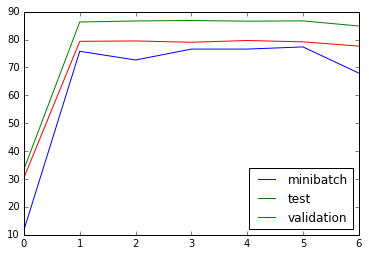

In [10]:
batch_size = 128
beta = 0.0001

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize '''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)
    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )
    
results = getResults(graph, 3001)
results.plot()

## Above, with Adjustable learning rate 

Initialized
Minibatch loss at step 0: 474.642670
Minibatch loss at step 500: 42.361042
Minibatch loss at step 1000: 74.282494
Minibatch loss at step 1500: 40.085381
Minibatch loss at step 2000: 38.190422
Minibatch loss at step 2500: 43.263569
Minibatch loss at step 3000: 32.723412
Minibatch loss at step 3500: 37.119656
Minibatch loss at step 4000: 21.049852
Minibatch loss at step 4500: 22.761265
Minibatch loss at step 5000: 24.585985
Minibatch loss at step 5500: 33.273804
Minibatch loss at step 6000: 16.840019
Minibatch loss at step 6500: 15.767641
Minibatch loss at step 7000: 16.809067
Minibatch loss at step 7500: 16.567289
Minibatch loss at step 8000: 17.249599
Minibatch loss at step 8500: 12.182506
Minibatch loss at step 9000: 13.861042
Test accuracy: 91.3%


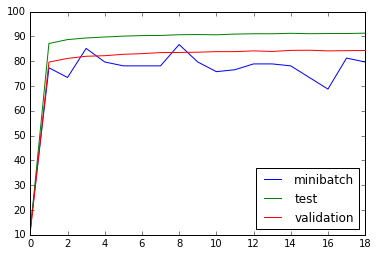

In [18]:
batch_size = 128
beta = 0.001

starter_learning_rate = 0.01
decay_steps = 100000
decay_rate = 0.96
staircase = True

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize with learning rate being adjusted '''
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(
        starter_learning_rate,
        global_step,
        decay_steps,
        decay_rate,
        staircase
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_l2)
    # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)

    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )
    
results = getResults(graph, 9001)
results.plot()

## More steps on above!

Initialized
Minibatch loss at step 0: 504.667542
Minibatch loss at step 500: 71.845901
Minibatch loss at step 1000: 74.292046
Minibatch loss at step 1500: 46.610199
Minibatch loss at step 2000: 39.847752
Minibatch loss at step 2500: 37.042236
Minibatch loss at step 3000: 34.767834
Minibatch loss at step 3500: 33.890205
Minibatch loss at step 4000: 28.350229
Minibatch loss at step 4500: 22.612356
Minibatch loss at step 5000: 24.005623
Minibatch loss at step 5500: 19.752203
Minibatch loss at step 6000: 19.282927
Minibatch loss at step 6500: 13.887416
Minibatch loss at step 7000: 19.731289
Minibatch loss at step 7500: 13.845834
Minibatch loss at step 8000: 20.749552
Minibatch loss at step 8500: 13.188600
Minibatch loss at step 9000: 11.955771
Minibatch loss at step 9500: 10.581141
Minibatch loss at step 10000: 8.737448
Minibatch loss at step 10500: 7.912391
Minibatch loss at step 11000: 8.271331
Minibatch loss at step 11500: 9.107540
Minibatch loss at step 12000: 6.824302
Minibatch loss a

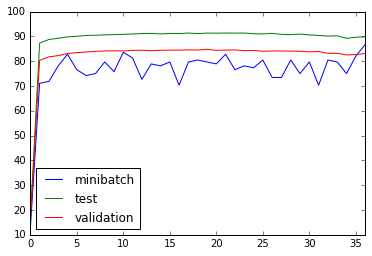

In [19]:
results = getResults(graph, 18001)
results.plot()

## Try without staircase

Initialized
Minibatch loss at step 0: 474.521820
Minibatch loss at step 500: 82.303070
Minibatch loss at step 1000: 79.664459
Minibatch loss at step 1500: 38.445599
Minibatch loss at step 2000: 39.482975
Minibatch loss at step 2500: 41.036152
Minibatch loss at step 3000: 33.605465
Minibatch loss at step 3500: 40.065220
Minibatch loss at step 4000: 35.544403
Minibatch loss at step 4500: 26.976303
Minibatch loss at step 5000: 21.705391
Minibatch loss at step 5500: 25.557566
Minibatch loss at step 6000: 15.751524
Minibatch loss at step 6500: 15.651579
Minibatch loss at step 7000: 16.146669
Minibatch loss at step 7500: 18.817150
Minibatch loss at step 8000: 25.981953
Minibatch loss at step 8500: 13.176536
Minibatch loss at step 9000: 14.898055
Test accuracy: 91.0%


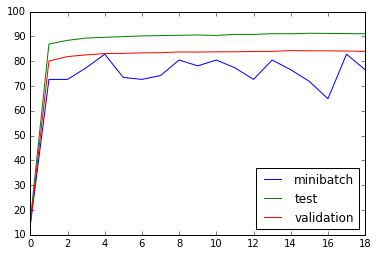

In [20]:
batch_size = 128
beta = 0.001

starter_learning_rate = 0.01
decay_steps = 100000
decay_rate = 0.96
staircase = False

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize with learning rate being adjusted '''
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(
        starter_learning_rate,
        global_step,
        decay_steps,
        decay_rate,
        staircase
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_l2)
    # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)

    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )
    
    
results = getResults(graph, 9001)
results.plot()

## Added global step to GDO

Initialized
Minibatch loss at step 0: 471.495239
Minibatch loss at step 500: 55.303528
Minibatch loss at step 1000: 65.699265
Minibatch loss at step 1500: 45.239727
Minibatch loss at step 2000: 41.572273
Minibatch loss at step 2500: 54.774696
Minibatch loss at step 3000: 34.677269
Minibatch loss at step 3500: 33.382103
Minibatch loss at step 4000: 36.092155
Minibatch loss at step 4500: 24.672216
Minibatch loss at step 5000: 22.934101
Minibatch loss at step 5500: 23.681767
Minibatch loss at step 6000: 24.799286
Minibatch loss at step 6500: 20.711287
Minibatch loss at step 7000: 15.203753
Minibatch loss at step 7500: 17.478598
Minibatch loss at step 8000: 21.567366
Minibatch loss at step 8500: 7.568035
Minibatch loss at step 9000: 14.593655
Test accuracy: 91.0%


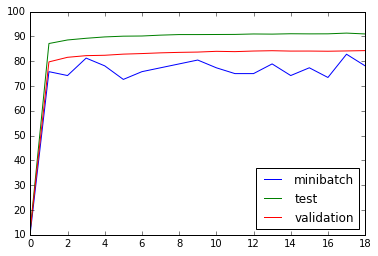

In [21]:
batch_size = 128
beta = 0.001

starter_learning_rate = 0.01
decay_steps = 100000
decay_rate = 0.96
staircase = False

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize with learning rate being adjusted '''
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(
        starter_learning_rate,
        global_step,
        decay_steps,
        decay_rate,
        staircase
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_l2, global_step=global_step)
    # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)

    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )
    
    
results = getResults(graph, 9001)
results.plot()

## Above with staircase on

Initialized
Minibatch loss at step 0: 499.036804
Minibatch loss at step 500: 61.826626
Minibatch loss at step 1000: 64.190704
Minibatch loss at step 1500: 33.071568
Minibatch loss at step 2000: 34.673206
Minibatch loss at step 2500: 41.867645
Minibatch loss at step 3000: 39.082767
Minibatch loss at step 3500: 32.325771
Minibatch loss at step 4000: 17.672661
Minibatch loss at step 4500: 22.983509
Minibatch loss at step 5000: 18.208973
Minibatch loss at step 5500: 24.067165
Minibatch loss at step 6000: 16.103811
Minibatch loss at step 6500: 11.877369
Minibatch loss at step 7000: 11.700448
Minibatch loss at step 7500: 18.024632
Minibatch loss at step 8000: 23.716696
Minibatch loss at step 8500: 11.785963
Minibatch loss at step 9000: 15.511315
Test accuracy: 91.3%


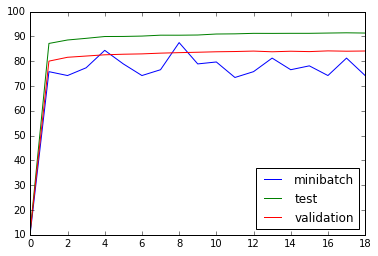

In [22]:
batch_size = 128
beta = 0.001

starter_learning_rate = 0.01
decay_steps = 100000
decay_rate = 0.96
staircase = True

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size * image_size)
    )
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels)
    )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_datast = tf.constant(test_dataset)
    
    ''' hidden layer '''
    num_nodes_hidden = 1024
    weights_hidden = tf.Variable(
        tf.truncated_normal([
            image_size * image_size,
            num_nodes_hidden
        ])
    )
    biases_hidden = tf.Variable(
        tf.zeros([num_nodes_hidden])
    )
    layer_hidden = tf.nn.relu(
        tf.matmul(
            tf_train_dataset,
            weights_hidden
        ) + biases_hidden
    )
    
    
    ''' dropout hidden layer '''
    prob_to_keep = tf.placeholder('float')
    layer_drop_hidden = tf.nn.dropout(
        layer_hidden,
        prob_to_keep
    )
    
    ''' variables '''
    weights = tf.Variable(
        tf.truncated_normal([
            num_nodes_hidden,
            num_labels
        ])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    ''' training computation function '''
    logits = tf.matmul(layer_drop_hidden, weights) + biases
    
    ''' loss function using L2 Regularization '''
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )
    loss_l2 = tf.reduce_mean(
        loss + beta * tf.nn.l2_loss(weights)
    )
    
    ''' optimize with learning rate being adjusted '''
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(
        starter_learning_rate,
        global_step,
        decay_steps,
        decay_rate,
        staircase
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_l2, global_step=global_step)
    # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_l2)

    
    ''' predictions '''
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(
        tf.matmul(
            tf_valid_dataset,
            weights_hidden
        ) + biases_hidden
    )
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            valid_relu,
            weights
        ) + biases
    )
    
    test_relu = tf.nn.relu(
        tf.matmul(
            tf_test_datast,
            weights_hidden
        ) + biases_hidden
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            test_relu,
            weights
        ) + biases
    )
    
    
results = getResults(graph, 9001)
results.plot()

## Try a second hidden layer

In [ ]:
batch_size = 128
beta = 0.001
num_steps = 9001

num_hidden_nodes_layer_1 = 1024
num_hidden_nodes_layer_2 = 512

starter_learning_rate = 0.001
decay_steps = 100000
decay_rate = 0.96
staircase = True

graph = tf.Graph()
with graph.as_default():
    ''' input data '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    ''' hidden layer 1'''
    hidden_weights_layer_1 = tf.Variable( tf.truncated_normal([image_size * image_size, num_hidden_nodes_layer_1]) )
    hidden_biases_layer_1 = tf.Variable( tf.zeros([num_hidden_nodes_layer_1]))
    hidden_layer_1 = tf.nn.relu( tf.matmul( tf_train_dataset, hidden_weights_layer_1) + hidden_biases_layer_1)
    keep_prob_layer_1 = tf.placeholder("float")
    hidden_layer_1_drop = tf.nn.dropout(hidden_layer_1, keep_prob_layer_1)
    
    ''' hidden layer 2 '''    
    hidden_weights_layer_2 = tf.Variable( tf.truncated_normal([num_hidden_nodes_layer_1, num_hidden_nodes_layer_2]) )
    hidden_biases_layer_2 = tf.Variable( tf.zeros([num_hidden_nodes_layer_2]))
    hidden_layer_2 = tf.nn.relu( tf.matmul( hidden_layer_1_drop, hidden_weights_layer_2) + hidden_biases_layer_2)
    keep_prob_layer_2 = tf.placeholder("float")
    hidden_layer_2_drop = tf.nn.dropout(hidden_layer_2, keep_prob_layer_2)
    
    weights = tf.Variable( tf.truncated_normal([num_hidden_nodes_layer_2, num_labels])) 
    biases = tf.Variable(tf.zeros([num_labels]))

    logits = tf.matmul(hidden_layer_2_drop, weights) + biases
    
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) )
    loss_l2 = tf.reduce_mean( loss + beta * tf.nn.l2_loss(weights) )

    global_step = tf.Variable(0, trainable=False)
    learnr = tf.placeholder("float")

    learning_rate = tf.train.exponential_decay(learnr, global_step, decay_steps, decay_rate, staircase=staircase)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_l2, global_step=global_step)

    train_prediction = tf.nn.softmax(logits)    
    
    valid_relu1 = tf.nn.relu(  tf.matmul(tf_valid_dataset, hidden_weights_layer_1) + hidden_biases_layer_1)    
    valid_relu2 = tf.nn.relu(  tf.matmul(valid_relu1, hidden_weights_layer_2) + hidden_biases_layer_2)    
    
    valid_prediction = tf.nn.softmax( tf.matmul(valid_relu2, weights) + biases) 
    
    test_relu1 = tf.nn.relu( tf.matmul( tf_test_dataset, hidden_weights_layer_1) + hidden_biases_layer_1)
    test_relu2 = tf.nn.relu( tf.matmul( test_relu1, hidden_weights_layer_2) + hidden_biases_layer_2)   
    
    test_prediction = tf.nn.softmax(tf.matmul(test_relu2, weights) + biases)
    
results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        _, l, predictions = session.run(
            [
                optimizer,
                loss,
                train_prediction
            ],
            feed_dict={
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels,
                keep_prob_layer_1 : 0.5,
                keep_prob_layer_2 : 0.25,
                learnr : starter_learning_rate
            }
        )
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
            print('')
            results.append({
                'minibatch': accuracy(predictions, batch_labels),
                'validation':accuracy(valid_prediction.eval(), valid_labels),
                'test': accuracy(test_prediction.eval(), test_labels)
            })
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


results = pd.DataFrame(results)
results.plot()

Initialized
Minibatch loss at step 0: 13057.684570
Minibatch accuracy: 13.3%
Validation accuracy: 12.4%
Test accuracy: 12.7%

Minibatch loss at step 500: 810.420837
Minibatch accuracy: 60.2%
Validation accuracy: 78.7%
Test accuracy: 86.0%

Minibatch loss at step 1000: 445.781403
Minibatch accuracy: 65.6%
Validation accuracy: 78.3%
Test accuracy: 85.3%

Minibatch loss at step 1500: 206.082321
Minibatch accuracy: 66.4%
Validation accuracy: 78.1%
Test accuracy: 85.2%

Minibatch loss at step 2000: 160.543121
Minibatch accuracy: 51.6%
Validation accuracy: 77.5%
Test accuracy: 84.6%

Minibatch loss at step 2500: 120.333481
Minibatch accuracy: 51.6%
Validation accuracy: 75.0%
Test accuracy: 82.1%

Minibatch loss at step 3000: 96.579292
Minibatch accuracy: 45.3%
Validation accuracy: 74.5%
Test accuracy: 81.3%

Minibatch loss at step 3500: 77.280273
Minibatch accuracy: 51.6%
Validation accuracy: 73.7%
Test accuracy: 80.5%

Minibatch loss at step 4000: 63.349602
Minibatch accuracy: 55.5%
Validat